In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
import nltk
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


# Osnovne informacije o datasetu

In [13]:
train_csv = pd.read_csv("../input/feedback-prize-english-language-learning/train.csv")
test_csv = pd.read_csv("../input/feedback-prize-english-language-learning/test.csv")

In [14]:
train_csv.info()
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_id    3 non-null      object
 1   full_text  3 non-null      object
dtypes: object(2)
memory usage: 176.0+ bytes


In [15]:
df_unique = np.unique(train_csv[train_csv.drop(labels=["text_id", "full_text"], axis=1).columns].values)
print(df_unique)

[1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


Nema nullova, imamo 3911 eseja na raspolaganju za treniranje +  još 3 u test datasetu

Osim toga y vrijednosti se nalaze između 1 i 5, sa korakom 0.5

# Analiza eseja

In [19]:
text_df = train_csv['full_text']

## 1. Broj riječi po eseju

Najmanji broj riječi: 82
Najveći broj riječi: 6044
Medijan broja riječi: 2173.0


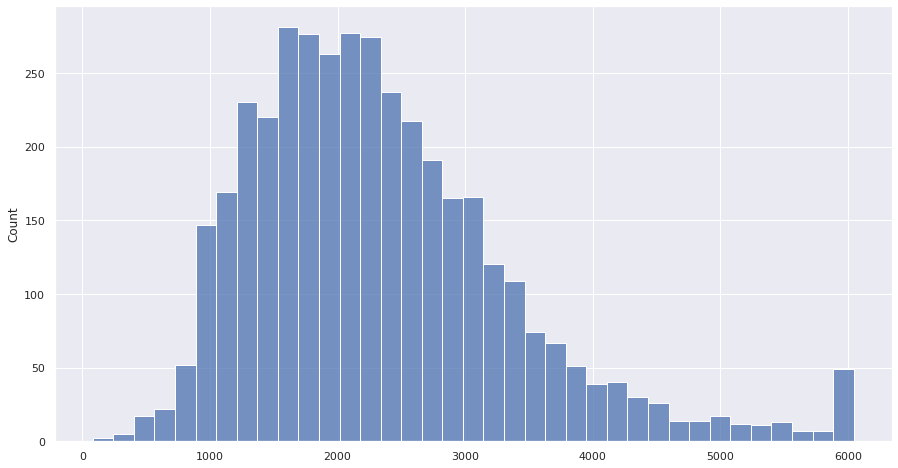

In [37]:
len_arr = [len(x) for x in text_df]
sns.histplot(len_arr)

print("Najmanji broj riječi: {}".format(min(len_arr)))
print("Najveći broj riječi: {}".format(max(len_arr)))
print("Medijan broja riječi: {}".format(np.median(len_arr)))

Čak skoro 50 ljudi je oko 6000 riječi pisalo, dosta nagli skok

## 2. Najčešće riječi u eseju

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<AxesSubplot:>

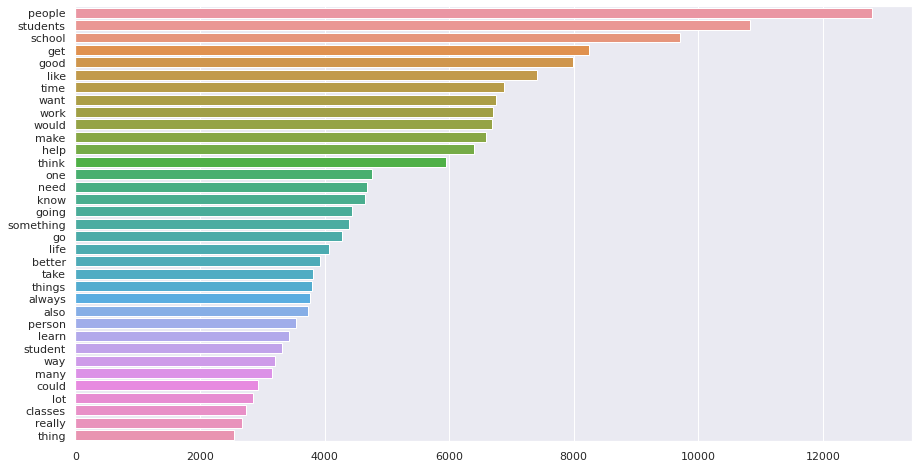

In [34]:
nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))

all_texts = [x.split() for x in text_df]
corpus = list()
for essay in all_texts:
    for word in essay:
        corpus.append(word)

counter = Counter(corpus)
most = counter.most_common()
x, y = list(), list()
for word, count in most [:100]:
    if (word.lower() not in stop):
        x.append(word)
        y.append(count)
        
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x=y, y=x)

Maknuo sam stopwordse poput **"I", "we", "the", "and"**, i slično tako da ovo ispada da su najčešće korištene riječi

## 3. Najčešći n-grami u eseju

In [43]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

print("Top 2-grams:")
print(get_top_ngram(corpus, 2))
print("Top 3-grams:")
print(get_top_ngram(corpus, 3))

Top 2-grams:
[('you re', 544), ('they re', 348), ('self esteem', 221), ('you ll', 217), ('four day', 189), ('he she', 120), ('they ll', 90), ('we re', 90), ('you ve', 87), ('his her', 78)]
Top 3-grams:
[('one on one', 3), ('music drama or', 3), ('person to person', 3), ('generic_name generic_name generic_name', 3), ('teachers friends and', 3), ('books shop and', 3), ('pain act and', 2), ('father in law', 2), ('phones computers and', 2), ('face to face', 2)]


Zanimljivo je za vidjet ovaj **('generic_name generic_name generic_name', 3)**

Trebalo bi istražit šta je to i vidjet da se izbaci iz dataseta

Printao sam i 4-grame, ali tu nema niti jedan sa većom pojavom od 1, tako da to se ne isplati gledat

## 4. Istraživanje sadržaja eseja

In [48]:
print(text_df[0])
print("\n------\n")
print(text_df[1])

I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.

The hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.

most students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go take a

Izgleda da su eseji o svakakvim temama, valjalo bi za dodatnu analizu pogledati koje su to najčešće teme o kojima se piše

Trebalo bi i pogledat korištene vrste riječi u esejima.

Sve to bi bilo kul da se usporedi sa target varijablama, da vidimo npr kako su po ocjenama raspodijeljene teme, korištenja pojedinih tipova riječi i slično